In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
pd.set_option('display.max_columns', None)

# Load the data


In [4]:
df = pd.read_csv('/content/vaccination_tweets.csv')
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


# Structural Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10340 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [6]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [7]:
df.isnull().sum()

,0
id,0
user_name,0
user_location,2270
user_description,680
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0


# Text Analytics

In [8]:
text_df = df[['text']]
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [9]:
for i in range(10):
  print(text_df['text'].iloc[i], '\n')

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 

Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN 

it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP 

There have not been many bright days in 2020 but here are so

# Data Preprocessing

In [10]:
nltk.download('punkt_tab') # Download the missing 'punkt_tab' resource

# Define a function to do following - lower, remove hyperlink, @tagging, #tags
def data_processing(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)

    text = re.sub('@\w+', '', text)
    text = re.sub('#\w+', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub('\w*\d\w*', '', text)
    # stop words
    stop_words = stopwords.words('english')
    words = word_tokenize(text) # This line should now work correctly
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
# apply the function
text_df.text = text_df['text'].apply(data_processing)

<ipython-input-11-a82581c3445d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.text = text_df['text'].apply(data_processing)


In [12]:
text_df['text']

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,russian vaccine created last years
3,facts immutable senator even youre ethically s...
4,explain need vaccine
...,...
11015,number cases today november remember observe s...
11016,first dose
11017,number cases today november remember observe s...
11018,developed new pill increased change survive di...


In [13]:
# remove duplicates
text_df = text_df.drop_duplicates()

In [14]:
text_df

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,russian vaccine created last years
3,facts immutable senator even youre ethically s...
4,explain need vaccine
...,...
11011,given worse headache astrazeneca
11012,yes children ages years receive onethird adult...
11013,back booster time first two tim
11014,already last month


# Stemming and Lemmatization

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_lemmatize(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)
    return text

def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmatized_words)
    return text

In [16]:
# apply stemming
# Fix: Replace 'stemming' with the correct function name 'stem_lemmatize' or 'lemmatize'
text_df['text'] = text_df['text'].apply(stem_lemmatize) # or text_df['text'].apply(lemmatize)

In [17]:
# apply lemmatization
text_df['text'] = text_df['text'].apply(lemmatize)

In [18]:
for i in range(10):
  print(text_df['text'].iloc[i])

folk said daikon past could treat cytokin storm
world wrong side histori year hope biggest vaccin effort weve ev
russian vaccin creat last year
fact immut senat even your ethic sturdi enough acknowledg born
explain need vaccin
anyon use adviceguid whether covid vaccin safe whilst breastfeed
bit sad claim fame success patriot competit usa canada uk
mani bright day best win
covid vaccin get
state start get monday say


# Syntactic Analysis

# Sentiment Analysis

In [19]:
from textblob import TextBlob
from wordcloud import WordCloud

In [20]:
text_df['polarity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [21]:
text_df.head(20)

,text,polarity
0,folk said daikon past could treat cytokin storm,-0.250000
1,world wrong side histori year hope biggest vac...,-0.500000
2,russian vaccin creat last year,0.000000
3,fact immut senat even your ethic sturdi enough...,0.000000
4,explain need vaccin,0.000000
5,anyon use adviceguid whether covid vaccin safe...,0.500000
6,bit sad claim fame success patriot competit us...,-0.100000
7,mani bright day best win,0.833333
8,covid vaccin get,0.000000
9,state start get monday say,0.000000


In [22]:
# define a function for sentiment label

def sentiment_label(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [23]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment_label)
text_df.head(20)

,text,polarity,sentiment
0,folk said daikon past could treat cytokin storm,-0.250000,negative
1,world wrong side histori year hope biggest vac...,-0.500000,negative
2,russian vaccin creat last year,0.000000,neutral
3,fact immut senat even your ethic sturdi enough...,0.000000,neutral
4,explain need vaccin,0.000000,neutral
5,anyon use adviceguid whether covid vaccin safe...,0.500000,positive
6,bit sad claim fame success patriot competit us...,-0.100000,negative
7,mani bright day best win,0.833333,positive
8,covid vaccin get,0.000000,neutral
9,state start get monday say,0.000000,neutral


<ipython-input-24-c88914fd9965>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=text_df, palette='PiYG', edgecolor='black')


Text(0, 0.5, 'Count')

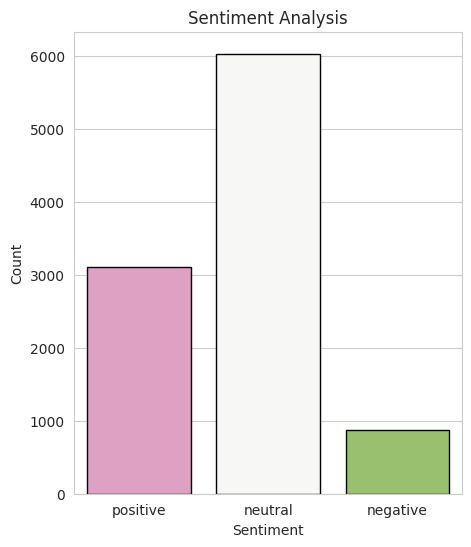

In [24]:
# visualize the results
sentiment_order = ['positive', 'neutral', 'negative']
text_df['sentiment'] = pd.Categorical(text_df['sentiment'], categories=sentiment_order, ordered=True)
sns.set_style('whitegrid')
plt.figure(figsize=(5,6) )
sns.countplot(x='sentiment', data=text_df, palette='PiYG', edgecolor='black')
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Text(0.5, 1.0, 'Sentiment Analysis')

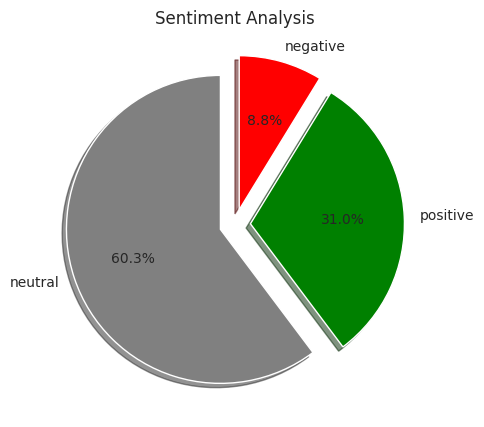

In [25]:
plt.figure(figsize=(5,5))
colors = ("grey", "green", "red")
explode = (0.1, 0.1, 0.1)
tags = text_df['sentiment'].value_counts()
plt.pie(tags, colors=colors, explode=explode, labels=tags.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Sentiment Analysis')

# Topic modelling

In [26]:
pos_tweets = text_df[text_df['sentiment'] == 'positive']
pos_tweets = pos_tweets.sort_values(by = 'polarity', ascending=False)
pos_tweets.head(10)

,text,polarity,sentiment
9394,dont worri govern realli care want best health,1.0,positive
6792,best news yet,1.0,positive
6299,best shot,1.0,positive
9317,best way get merrygoround,1.0,positive
2004,fulli vaccin covid best gift thank help amp te...,1.0,positive
5542,best gift gift,1.0,positive
1055,alreadi vaccin get vaccin soon plan abroad bes...,1.0,positive
7362,two best vaccin avail u,1.0,positive
4764,best effort,1.0,positive
864,oh best explan vaccin immun respons,1.0,positive


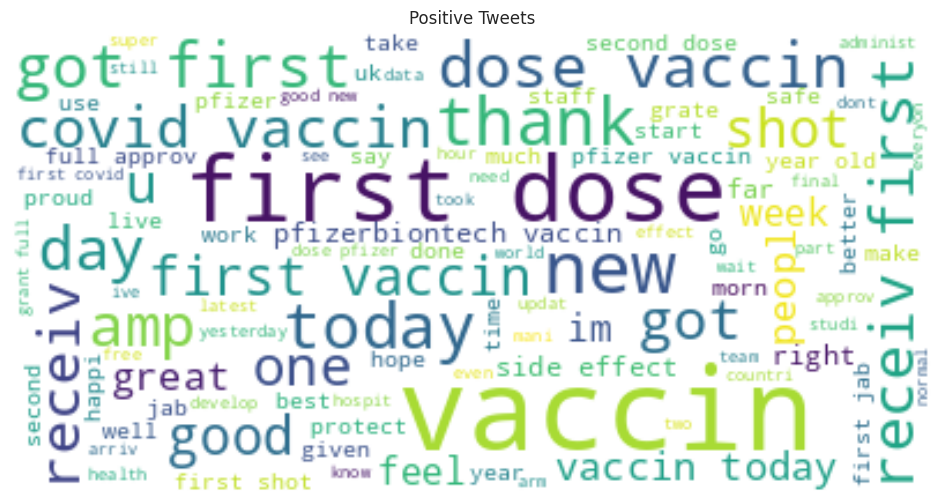

In [27]:
# wordcloud for positive tweets
sns.set_style('darkgrid')
pos_tweets_text = ' '.join(word for word in pos_tweets['text'])
plt.figure(figsize=(12,6))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(pos_tweets_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets')
plt.show()

# **Classification with different models**

In [49]:
# Features and target variable
X = text_df['text']
y = text_df['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting sets
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (8003,)
X_test shape: (2001,)
y_train shape: (8003,)
y_test shape: (2001,)


# TF-IDF Vectorization and Logistic Regression:

In [50]:
# 1. Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) # You can experiment with different ngram ranges

# 2. Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# 3. Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf.transform(X_test)

# 4. Initialize a Logistic Regression model
model = LogisticRegression(max_iter=1000) # Increase max_iter if needed

# 5. Train the model
model.fit(X_train_tfidf, y_train)

# 6. Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# 7. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.856071964017991
              precision    recall  f1-score   support

    negative       0.85      0.16      0.27       181
     neutral       0.82      1.00      0.90      1192
    positive       0.96      0.79      0.86       628

    accuracy                           0.86      2001
   macro avg       0.88      0.65      0.68      2001
weighted avg       0.87      0.86      0.83      2001



# visualizing the confusion matrix

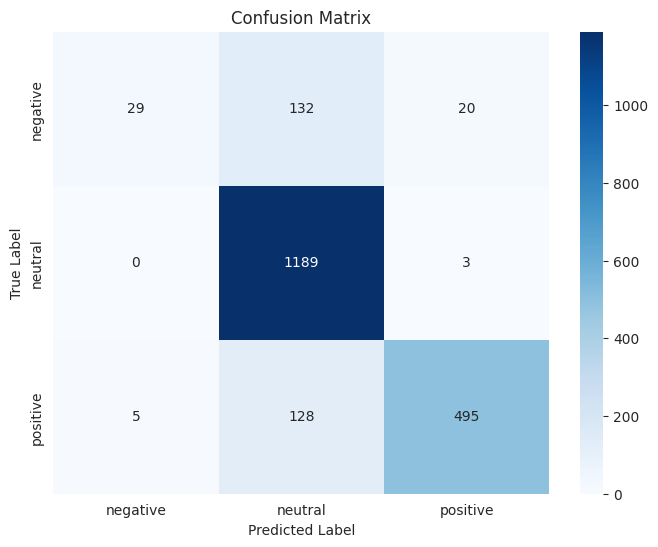

In [41]:
from sklearn.metrics import confusion_matrix

# Assuming you have already trained your model and obtained y_pred

# 1. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Gradient Boosting:

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

# 1. Initialize a Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 2. Train the model (using TF-IDF features)
gb_model.fit(X_train_tfidf, y_train)

# 3. Make predictions
y_pred_gb = gb_model.predict(X_test_tfidf)

# 4. Evaluate the model
print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Accuracy (Gradient Boosting): 0.8705647176411794
              precision    recall  f1-score   support

    negative       0.82      0.39      0.53       181
     neutral       0.84      1.00      0.91      1192
    positive       0.97      0.77      0.86       628

    accuracy                           0.87      2001
   macro avg       0.88      0.72      0.76      2001
weighted avg       0.88      0.87      0.86      2001



# Naive Bayes:

In [44]:
from sklearn.naive_bayes import MultinomialNB

# 1. Initialize a Multinomial Naive Bayes model
nb_model = MultinomialNB()

# 2. Train the model (using TF-IDF features from previous example)
nb_model.fit(X_train_tfidf, y_train)

# 3. Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# 4. Evaluate the model
print("Accuracy (Naive Bayes):", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Accuracy (Naive Bayes): 0.7526236881559221
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       181
     neutral       0.72      1.00      0.83      1192
    positive       0.93      0.51      0.66       628

    accuracy                           0.75      2001
   macro avg       0.55      0.50      0.50      2001
weighted avg       0.72      0.75      0.70      2001



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Support Vector Machines (SVM):

In [52]:
from sklearn.svm import SVC

# 1. Initialize an SVM model
svm_model = SVC(kernel='linear') # You can experiment with different kernels

# 2. Train the model (using TF-IDF features)
svm_model.fit(X_train_tfidf, y_train)

# 3. Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# 4. Evaluate the model
print("Accuracy (SVM):", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy (SVM): 0.935032483758121
              precision    recall  f1-score   support

    negative       0.89      0.64      0.74       181
     neutral       0.93      1.00      0.96      1192
    positive       0.96      0.90      0.93       628

    accuracy                           0.94      2001
   macro avg       0.93      0.85      0.88      2001
weighted avg       0.93      0.94      0.93      2001



# K-Nearest Neighbors (KNN)

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Initialize a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5) # Experiment with different values of n_neighbors

# 2. Train the model (using TF-IDF features)
knn_model.fit(X_train_tfidf, y_train)

# 3. Make predictions
y_pred_knn = knn_model.predict(X_test_tfidf)

# 4. Evaluate the model
print("Accuracy (KNN):", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Accuracy (KNN): 0.6081959020489756
              precision    recall  f1-score   support

    negative       1.00      0.01      0.01       181
     neutral       0.60      1.00      0.75      1192
    positive       0.96      0.04      0.08       628

    accuracy                           0.61      2001
   macro avg       0.85      0.35      0.28      2001
weighted avg       0.75      0.61      0.47      2001



# Random Forest:

In [54]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Adjust parameters as needed

# 2. Train the model (using TF-IDF features)
rf_model.fit(X_train_tfidf, y_train)

# 3. Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# 4. Evaluate the model
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy (Random Forest): 0.9335332333833083
              precision    recall  f1-score   support

    negative       0.88      0.59      0.71       181
     neutral       0.93      1.00      0.96      1192
    positive       0.96      0.91      0.93       628

    accuracy                           0.93      2001
   macro avg       0.92      0.83      0.87      2001
weighted avg       0.93      0.93      0.93      2001



# performing hyper-parameter tuning

In [55]:
# # Performing hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

In [57]:
# Setting parametr values
param_grid = {'C':[0.001,0.01,0.1,1,10]}
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=3)
grid.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.605 total time=   0.5s
[CV 2/5] END ...........................C=0.001;, score=0.604 total time=   0.4s
[CV 3/5] END ...........................C=0.001;, score=0.604 total time=   0.4s
[CV 4/5] END ...........................C=0.001;, score=0.604 total time=   0.6s
[CV 5/5] END ...........................C=0.001;, score=0.604 total time=   0.4s
[CV 1/5] END ............................C=0.01;, score=0.606 total time=   0.9s
[CV 2/5] END ............................C=0.01;, score=0.606 total time=   0.7s
[CV 3/5] END ............................C=0.01;, score=0.604 total time=   0.8s
[CV 4/5] END ............................C=0.01;, score=0.606 total time=   0.6s
[CV 5/5] END ............................C=0.01;, score=0.605 total time=   1.1s
[CV 1/5] END .............................C=0.1;, score=0.701 total time=   1.2s
[CV 2/5] END .............................C=0.1;,

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=3)

In [58]:
# Printing best parameters
print("The best parameters: ",grid.best_params_)

The best parameters:  {'C': 10}
